In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('../../../../src')

In [2]:
from data import PolygonSentenceReader, Polygon
from modules import NLLLoss, ELBOLoss, MLP, Attention
from neural_process.models.np import CNP, LNP
from neural_process.models.attnnp import AttnCNP, AttnLNP
from utils import plot_polygon

import datetime
from functools import partial
import random
import torch
import torch.nn as nn
from torch.distributions.kl import kl_divergence

In [20]:
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)
BATCH_SIZE = 128
MAX_CONTEXT_POINTS = 15
MIN_SIDES = 3
MAX_SIDES = 8
x_size = 4 + 3 * MAX_SIDES
y_size = MAX_SIDES
r_size = 224
torch.manual_seed(0)

criterion = ELBOLoss()

# Instantiate a polygon generator.
# (For example, polygons with between 3 and 8 sides.)
polygon_generator_train = PolygonSentenceReader(
    batch_size=BATCH_SIZE,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MAX_SIDES,
    center=(5, 5),
    radius=3,
    testing=False,
)

polygon_generator_test = PolygonSentenceReader(
    batch_size=100,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MIN_SIDES,
    center=(5, 5),
    radius=3,
    testing=True,
)

Encoder = partial(
    MLP,
    n_hidden_layers=2,
    hidden_size=r_size,
)

Decoder = partial(
    MLP,
    n_hidden_layers=5,
    hidden_size=r_size,
    dropout=0.1,
)

LatentEncoder = partial(
    MLP,
    n_hidden_layers=3,
    hidden_size=r_size,
    dropout=0.1,
)


model = AttnLNP(
    x_dim=x_size, 
    y_dim=y_size, 
    r_dim=r_size, 
    attention_type="multihead", 
    n_z_train=10, 
    n_z_test=10,
    Encoder=Encoder,
    LatentEncoder=LatentEncoder,
    Decoder=Decoder,
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=TRAINING_ITERATIONS, eta_min=1e-6
)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = next(model.parameters()).device
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 1,540,240


# Training

In [21]:
train_losses = []
test_losses  = []
iters_list = []

# ----------------------
# Training Loop
# ----------------------
for it in range(1, TRAINING_ITERATIONS + 1):
    # Generate a batch of polygon completion tasks.
    (
        context_x,
        context_y,
        target_x,
        target_y,
        tokens,
        true_poly,
        max_seq_len,
        num_context,
        context_masks,
    ) = polygon_generator_train.generate_polygon_batch_few_shot_completion_task()

    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y.to(device)
    context_masks = context_masks.to(device)

    optimizer.zero_grad()
    # Forward pass: the NP model expects context_x, context_y, target_x, target_y.
    dist, z, q_zc, q_zct = model(context_x, context_y, target_x, target_y)
    loss = criterion(dist, q_zct, q_zc, target_y, mask=context_masks)
    loss.backward()
    optimizer.step()
    scheduler.step()

    train_losses.append(loss.item())

    if it % 1000 == 0:
        print("Iteration: {}, train loss: {}".format(it, loss.item()))

    # ----------------------
    # Evaluation and Plotting
    # ----------------------
    if it % PLOT_AFTER == 0:
        # For plotting, we generate a single polygon sample.
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            tokens_eval,
            true_poly_eval,
            max_seq_len_eval,
            num_context_eval,
            context_masks_eval,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task()

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval = target_x_eval.to(device)
        target_y_eval = target_y_eval.to(device)
        context_masks_eval = context_masks_eval.to(device)

        # Forward pass through the model.
        test_dist, test_z, test_q_zc, test_q_zct = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss = criterion(test_dist, test_q_zct, test_q_zc, target_y_eval, mask=context_masks_eval)
        test_losses.append(loss.item())
        iters_list.append(it)

        print(
            "{}, Iteration: {}, Test Loss: {}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                it,
                loss.item(),
            )
        )

        # Get NP predictions on target tokens (taking the mean of the predictive distribution).
        pred_target = test_dist.mean  # shape: [n_z, batch, n_target, y_dim]

        # For simplicity, we average over latent samples and batch dimension.
        pred_target_avg = pred_target.mean(0)[0, -1, :]  # shape: [batch, n_target, y_dim]
        true_polygon = true_poly_eval[0]
        true_polygon_tokenised = true_polygon.to_tokenised()
        pred_target_avg = pred_target_avg[:len(true_polygon.angles)].tolist()

        print("True Polygon: ", true_polygon)
        print("True Polygon Angles: ", true_polygon.angles)
        print("Predicted Polygon Angles: ", pred_target_avg)

Iteration: 1000, train loss: 110214.8359375
Iteration: 2000, train loss: 24397.974609375
Iteration: 3000, train loss: 11470.9541015625
Iteration: 4000, train loss: 2373.1513671875
Iteration: 5000, train loss: 1841.931396484375
Iteration: 6000, train loss: 153.0408477783203
Iteration: 7000, train loss: 116.79782104492188
Iteration: 8000, train loss: 162.3307647705078
Iteration: 9000, train loss: 912.4454345703125
Iteration: 10000, train loss: 149.99465942382812
Iteration: 11000, train loss: 11.134172439575195
Iteration: 12000, train loss: 11.728816032409668
Iteration: 13000, train loss: 24.575576782226562
Iteration: 14000, train loss: 10.684013366699219
Iteration: 15000, train loss: 8.121124267578125
Iteration: 16000, train loss: 6.897250175476074
Iteration: 17000, train loss: 8.575541496276855
Iteration: 18000, train loss: 6.526318550109863
Iteration: 19000, train loss: 6.475636959075928
Iteration: 20000, train loss: 6.614295959472656
2025-05-13 17:56:10, Iteration: 20000, Test Loss: 6

In [ ]:
checkpoint = {
    'iteration': it,                                 
    'model_state_dict': model.state_dict(),         
    'optimizer_state_dict': optimizer.state_dict(),  
    'scheduler_state_dict': scheduler.state_dict(),  
}

torch.save(model.state_dict(), "../models/polygon/np/angle_completion_task/" + model.__class__.__name__ + ".pt")
torch.save(checkpoint, "../models/polygon/np/" + model.__class__.__name__ + "_checkpoint.pt")
print(f"Saved final checkpoint at iteration {it} → ../models/polygon/np/" + model.__class__.__name__ + "_checkpoint.pt")

In [5]:
model.load_state_dict(
    torch.load("../models/polygon/np/angle_completion_task/" + model.__class__.__name__ + ".pt")
)

<All keys matched successfully>

# In-distribution performance over polygons of length 3 to 8 at varying numbers of context points

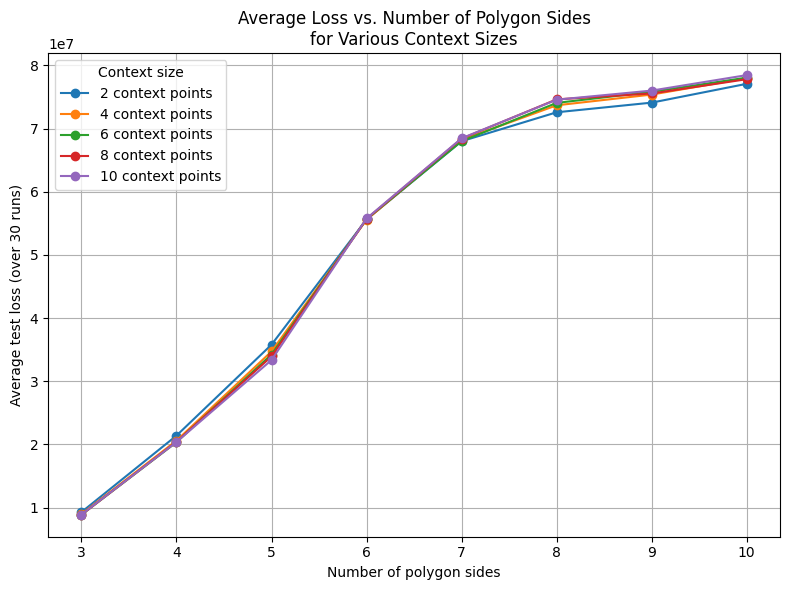

In [27]:
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 64
sides_list = list(range(3, 11))
context_points_list = [2, 4, 6, 8, 10]
criterion = ELBOLoss()

plt.figure(figsize=(8, 6))

with torch.no_grad():
    for num_context in context_points_list:
        avg_losses = []
        for sides in sides_list:
            losses = []
            polygon_generator_test = PolygonSentenceReader(
                batch_size=BATCH_SIZE,
                max_num_context=num_context,
                max_seq_len=x_size,
                min_num_sides=sides,
                max_num_sides=sides,
                center=(5, 5),
                radius=3,
                testing=True,
            )
            for _ in range(30):
                (
                    context_x_eval,
                    context_y_eval,
                    target_x_eval,
                    target_y_eval,
                    *_,
                ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task(num_context)

                context_x_eval = context_x_eval.to(device)
                context_y_eval = context_y_eval.to(device)
                target_x_eval = target_x_eval.to(device)
                target_y_eval = target_y_eval.to(device)

                test_dist, _, q_zc, q_zct = model(
                    context_x_eval, context_y_eval, target_x_eval, target_y_eval
                )
                loss = criterion(test_dist, q_zct, q_zc, target_y_eval)
                losses.append(loss.item())

            avg_losses.append(np.mean(losses))

        plt.plot(sides_list,
                avg_losses,
                marker='o',
                label=f'{num_context} context{" point" if num_context==1 else " points"}')

plt.xlabel("Number of polygon sides")
plt.ylabel("Average test loss (over 30 runs)")
plt.title("Average Loss vs. Number of Polygon Sides\nfor Various Context Sizes")
plt.xticks(sides_list)
plt.grid(True)
plt.legend(title="Context size")
plt.tight_layout()
plt.show()

# Out-of-distribution

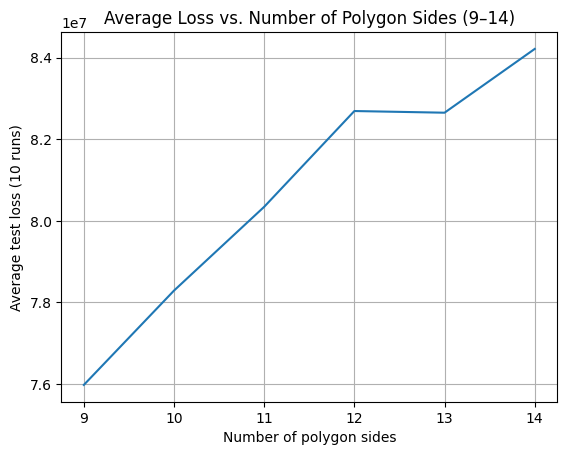

In [28]:
sides_list = list(range(9, 15))
avg_losses = []

for sides in sides_list:
    losses = []
    for run in range(30):
        poly_gen = PolygonSentenceReader(
            batch_size=BATCH_SIZE,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=sides,
            max_num_sides=sides,
            center=(5, 5),
            radius=3,
            testing=True,
        )
        (cx, cy, tx, ty, *_) = poly_gen.generate_polygon_batch_few_shot_completion_task(10)
        cx, cy, tx, ty = cx.to(device), cy.to(device), tx.to(device), ty.to(device)

        dist, z, q_zc, q_zct = model(cx, cy, tx, ty)
        loss = criterion(dist, q_zct, q_zc, ty)
        losses.append(loss.item())

    avg_losses.append(np.mean(losses))

# Plot
plt.figure()
plt.plot(sides_list, avg_losses)
plt.xlabel("Number of polygon sides")
plt.ylabel("Average test loss (10 runs)")
plt.title("Average Loss vs. Number of Polygon Sides (9–14)")
plt.xticks(sides_list)
plt.grid(True)
plt.show()

# In-distribution performance over polygons of length 5 over context points 3 to 10 over 10 runs

Sides: 5, Context: 3, Mean Loss: 34595465.0667 ± 548780.6555
Sides: 5, Context: 4, Mean Loss: 34087212.4667 ± 536412.4172
Sides: 5, Context: 5, Mean Loss: 34193634.1333 ± 662137.6149
Sides: 5, Context: 6, Mean Loss: 34047797.7333 ± 679143.0556
Sides: 5, Context: 7, Mean Loss: 33656528.2667 ± 646752.8780
Sides: 5, Context: 8, Mean Loss: 33728854.1333 ± 525166.2099
Sides: 5, Context: 9, Mean Loss: 33583696.9333 ± 558055.2151
Sides: 5, Context: 10, Mean Loss: 33511012.4000 ± 421464.8259


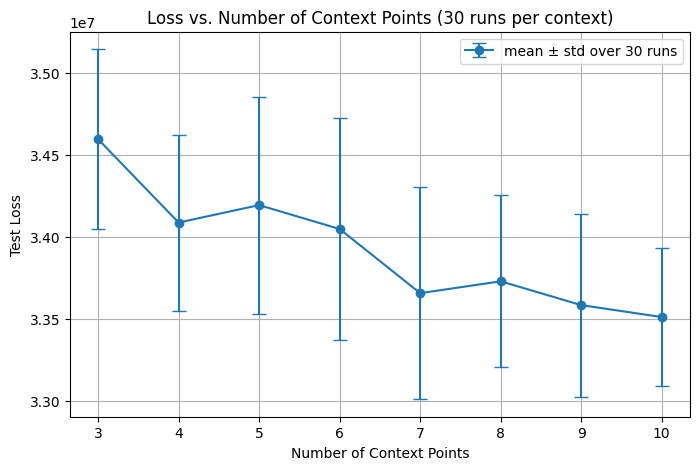

In [26]:
context_values = list(range(3, 11))
runs = 30

# holders for plotting
all_contexts = []
all_losses   = []
mean_losses  = []
std_losses   = []

for context in context_values:
    losses = []
    for run in range(runs):
        # --- generate one evaluation batch ---
        polygon_generator_test = PolygonSentenceReader(
            batch_size=100,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=5,
            max_num_sides=5,
            center=(5, 5),
            radius=3,
            testing=True,
        )
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            tokens_eval,
            true_poly_eval,
            max_seq_len_eval,
            num_context_eval,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task(context)

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval  = target_x_eval.to(device)
        target_y_eval  = target_y_eval.to(device)

        # forward + loss
        test_dist, test_z, test_q_zc, test_q_zct = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss = criterion(test_dist, test_q_zct, test_q_zc, target_y_eval)
        l = loss.item()
        losses.append(l)

        # keep for scatter
        all_contexts.append(context)
        all_losses.append(l)

    # after 10 runs, record mean & std
    mean_losses.append(np.mean(losses))
    std_losses.append(np.std(losses))
    print(f"Sides: 5, Context: {context}, "
          f"Mean Loss: {mean_losses[-1]:.4f} ± {std_losses[-1]:.4f}")

# now plot
plt.figure(figsize=(8,5))
# scatter of all individual runs
# plt.scatter(all_contexts, all_losses, alpha=0.4, label="individual runs")
# error‐bars for mean ± std
plt.errorbar(context_values, mean_losses, yerr=std_losses,
             fmt='-o', capsize=5, label="mean ± std over 30 runs")

plt.xlabel("Number of Context Points")
plt.ylabel("Test Loss")
plt.title("Loss vs. Number of Context Points (30 runs per context)")
plt.xticks(context_values)
plt.grid(True)
plt.legend()
plt.show()